# Onward Challenge - Starter Notebook

Welcome to the Sirius Challenge, which explores the world of oil and gas production. For this challenge, data are bottom hole pressure time series from oil and gas wells. Bottom hole pressures are key metrics in energy production, as they document the pressures present deep within the earth's subsurface reservoirs. These pressures in turn help characterize the interactions between rock formations and the fluids moving within them. By monitoring and analyzing bottom hole pressures, we can optimize well design, production rates, and maximize the fluid recovery from each well. Understanding and monitoring these pressures also helps us detect for wellbore instability or formation damage. This helps us safeguard personnel, protect the environment, and mitigate potential hazards.

The data contains measurements of the pressure at the bottom of each well in one minute intervals. These data show how the pressure in each well changes when they are opened and closed (flowing and shut in, respectively) over time. For producing wells, pressures generally rise while shut in, and decrease while flowing. Due to sensor errors some of the data in the time series are erroneous or missing.

This challenge asks you to build a model to predict if a well is flowing or shut in. That is to say, the time intervals in which they occur. The model should take into account the shape of the time series, and the pressure values over time. Keep in mind that we consider producing and injecting wells, so increases or decreases must be identified depending on the case.

For more context see the Challenge Outline.

Through this notebook we will guide you through the data, the functions and classes we built for you, and the way you should approach the challenge. We'll begin with an introduction to the data and concepts involved. Then, we'll delve into exploring existing predictions and how to make your own informed guesses. The heart of the document will focus on building and using predictive models to infer shut-in time intervals. Next, you'll learn about generating submission files, the format used to present your predictions for evaluation. After that, we'll explore the evaluation procedure of submisions and, finally, the document will showcase examples of how this evaluation is used to assess the quality of your predictions.

Code for classes and functions are available in the `utils.py` file. For your solution to be accepted, you should use these classes and function. In particular, you should pay attention to the generation of submissions.

# Table of Contents:
## [1. Introduction](#first-bullet)
### [1.1. Supplied Materials](##)
### [1.2. Imports](##)
### [1.3. Exploration of train data and labels](##)
## [2. Exploration of predictions](#second-bullet)
### [2.1. Baseline predictions](##)
### [2.2. Illustrative predictions](##)
## [3. Building and using predictive models](#third-bullet)
### [3.1. Training](##)
### [3.2. Predicting](##)
## [4. Generation of submission files](#fourth-bullet)
## [5. Evaluation procedure](#fifth-bullet)
### [5.1. Baseline and illustrative predictions](##)
### [5.2. List of predictions](##)
## [6. Examples of evaluations](#sixth-bullet)

# 1. Introduction

Well dynamics are represented by a one-dimensional time series sampled at one-minute intervals and where the feature `y`, represents the bottom hole pressure value. The target feature is the list of time intervals $\{[start_1,stop_1),[start_2,stop_2),\ldots\}$ in which the well is shut in.

Given a time series $data$ of a well, a `prediction` is a list of time intervals inferred to be the label (target value) for that well. Thus, the challenge objective is to predict the shut-in labels. 

To do this, you have labeled time-series data points and the ground truth labels to train and validate a predictive model. That is to say, you have access to the train data and train labels. Note that a ground truth label is a list of intervals.

While the challenge is open you will be able to also access test data, but not the labels of these. We will use the labels to evaluate your predictions.

## 1.1 Supplied Materials:

* Starter Notebook
* Train data and labels: data/train/ 
* Examples of baseline results: data/baseline_intervals/
* Submission examples: sample_submissions/
* `utils.py` script containing helpful functions
* `requirements.txt` for all required packages

## 1.2. Imports

In [1]:
# ONLY RUN THIS CELL ONCE
# !pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from utils import *
import os

## 1.3. Exploration of train data and labels

Let's explore `data/train`. The dataset provided for this challenge consists of time series bottom hole pressures, `name.csv` and the associated ground truth labels `name_intervals.csv`. We included 200 of these pairs of files, each one with a different name.

Each file `name.csv` stores the one-dimensional time series with the feature `y` as explained above.
Each file `data_intervals.csv` has columns start and stop that, for each row represent a time interval of the ground truth label. 

We will review data of `example1` and `example2`

### Example 1

In [3]:
# read the data file
example1 = pd.read_csv("data/train/example1.csv",sep="\t")

In [4]:
# adjust the format
example1 = example1[['time','y']]

In [5]:
# general information
example1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576800 entries, 0 to 1576799
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   time    1576800 non-null  float64
 1   y       1576703 non-null  float64
dtypes: float64(2)
memory usage: 24.1 MB


In [6]:
# display data info
# summary
example1.describe()

time             y
count  1.576800e+06  1.576703e+06
mean   7.883995e+05  2.047104e+03
std    4.551831e+05  7.739114e+02
min    0.000000e+00  1.100100e+03
25%    3.941998e+05  1.332429e+03
50%    7.883995e+05  1.905019e+03
75%    1.182599e+06  2.660313e+03
max    1.576799e+06  3.846706e+03

In [7]:
# data dimensions
example1.shape

(1576800, 2)

In [8]:
# Reading ground truth label
example1_ground_truth_label = pd.read_csv("data/train/example1_intervals.csv")

In [9]:
# Converting into a list of intervals
example1_ground_truth_label = list(zip(example1_ground_truth_label.start,example1_ground_truth_label.stop))

In [10]:
example1_ground_truth_label

[(55613, 90222),
 (101241, 101544),
 (256613, 296764),
 (347872, 391785),
 (401269, 401475),
 (527030, 568054),
 (649037, 688258),
 (741955, 802294),
 (828360, 865777),
 (992950, 1019856),
 (1135027, 1180801),
 (1250239, 1250499),
 (1460336, 1520206)]

Visualization of the time series and the ground truth label: `y` over time, $(time,y)$ points with $time$ belonging to the groud truth label (list of intervals) in red color.

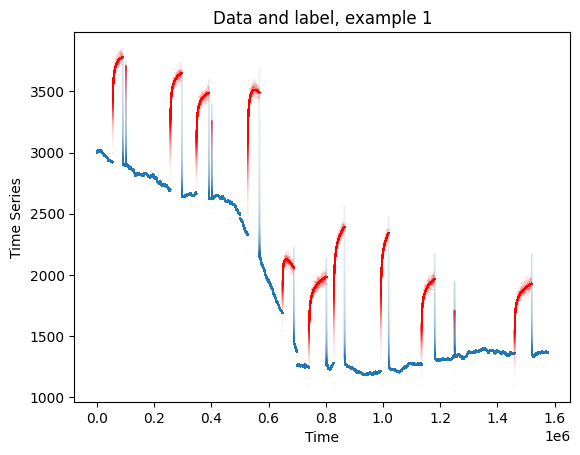

In [11]:
# Visualization of data and ground truth label
plot_well(example1_ground_truth_label,example1,title="Data and label, example 1",s=0.001)

We observe the behavior for `y` with and without `example1_ground_truth_label`. The 13 time intervals are highlighted in red.

### Example 2

In [12]:
# read the data file
example2 = pd.read_csv("data/train/example2.csv",sep="\t")

In [13]:
# adjust the format
example2 = example2[['time','y']]

In [14]:
# General information
example2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576800 entries, 0 to 1576799
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   time    1576800 non-null  float64
 1   y       1201702 non-null  float64
dtypes: float64(2)
memory usage: 24.1 MB


In [15]:
# display data info
# summary
example2.describe()

time             y
count  1.576800e+06  1.201702e+06
mean   7.883995e+05  3.858864e+03
std    4.551831e+05  1.830507e+03
min    0.000000e+00  2.784995e+02
25%    3.941998e+05  1.926827e+03
50%    7.883995e+05  4.211252e+03
75%    1.182599e+06  5.304553e+03
max    1.576799e+06  7.145876e+03

In [16]:
# data dimensions
example2.shape

(1576800, 2)

In [17]:
# Reading ground truth label
example2_ground_truth_label = pd.read_csv("data/train/example2_intervals.csv")

In [18]:
# Coverting into a list of intervals
example2_ground_truth_label = list(zip(example2_ground_truth_label.start,example2_ground_truth_label.stop))

In [19]:
example2_ground_truth_label

[(38942, 70899),
 (101261, 101574),
 (246391, 292265),
 (326942, 354777),
 (452226, 503362),
 (528543, 584561),
 (601308, 601638),
 (727945, 754252),
 (845021, 905489),
 (989331, 1046260),
 (1147420, 1187292),
 (1307377, 1338467),
 (1454845, 1505710)]

Visualization of the time series and the ground truth label: `y` over time, $(time,y)$ points with $time$ belonging to the groud truth label (list of intervals) in red color.

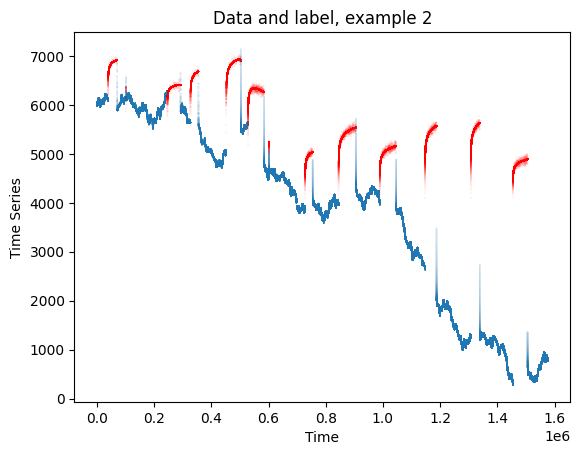

In [20]:
# Visualization of data and actual intervals: y over time, red color within shut in intervals
plot_well(example2_ground_truth_label,example2,title="Data and label, example 2",s=0.001)

We observe the behavior for `y` with and without `example2_ground_truth_label`. The 13 time intervals are highlighted in red. The noise we see outside the `example2_ground_truth_label` intervals is higher than in the previous example.

# 2. Exploration of predictions

## 2.1. Baseline predictions

### Exploration of baseline solutions

Let's explore some baseline predictions; that is to say, a previously found list of shut-in intervals for example 1 and example 2. We illustrate them by the same `plot_well` function we used before.

Folder `data/baseline_intervals/` contains baseline predictions `example1_baseline_prediction.csv`. These are a list of time intervals with the same format of the actual list of intervals.

### Example 1

In [21]:
# Reading prediction from baseline prediction
example1_baseline_prediction = pd.read_csv("data/baseline_intervals/example1_baseline_prediction.csv")

In [22]:
# Converting into a list of intervals
example1_baseline_prediction = list(zip(example1_baseline_prediction.start,example1_baseline_prediction.stop))

Visualization of the time series and the ground truth label: 'y' over time, $(time,y)$ points with $time$ belonging to 'example1_baseline_prediction' in red color.

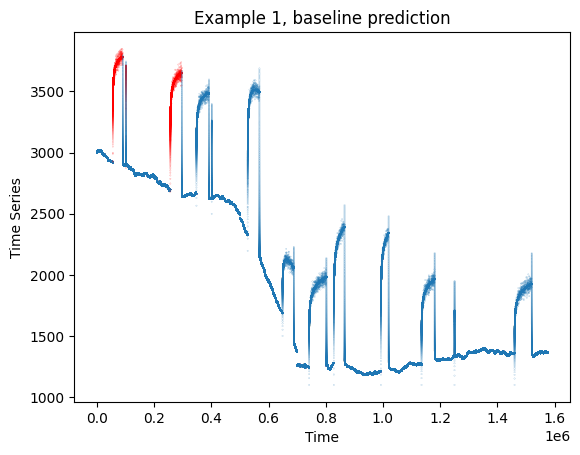

In [23]:
# Visualization of the data and baseline prediction: y over time, red color within "baseline-predicted" shut in intervals  
plot_well(example1_baseline_prediction,example1,title="Example 1, baseline prediction",s=0.01)

Note that only the first 3 intervals were identified

We can access the predicted interval

In [24]:
example1_baseline_prediction

[(55612, 90222), (101240, 101544), (256612, 296764)]

### Example 2

In [25]:
# Reading prediction from baseline prediction
example2_baseline_prediction = pd.read_csv("data/baseline_intervals/example2_baseline_prediction.csv")

In [26]:
# Converting into a list of intervals
example2_baseline_prediction = list(zip(example2_baseline_prediction.start,example2_baseline_prediction.stop))

Visualization of the time series and the ground truth label: `y` over time, $(time,y)$ points with $time$ belonging to 'example2_baseline_prediction' in red color.

In [27]:
# Visualization of the data and baseline prediction: y over time, red color within "baseline-predicted" shut in intervals  
plot_well(example2_baseline_prediction,example2,title="Example 2, baseline prediction",s=0.01)

Note that the first six intervals were not identified

## 2.2. Exploration of illustrative predictions 

### Example 1

An illustrative prediction:
List of intervals directly created

In [28]:
example1_illustrative_prediction= [(55000,100000),(255000,400000),(525000,865000),(990000,1020000),(1135000,1250000),(1460000,1500000)]

Visualization of the time series and the ground truth label: `y` over time, $(time,y)$ points with $time$ belonging to `example1_illustrative_prediction` in red color.

In [29]:
# Visualization of the data and an illustrative prediction: y over time, red color within predicted shut in intervals
plot_well(example1_illustrative_prediction,example1,title="Example 1, an ilustrative prediction",s=0.01)

This prediction identifies more intervals but combines four of them

Note that `plot_well` allows you generate diagrams for particular time ranges. 
Be careful to select the proper value for `s`, the higher the `s` value the greater the zoom.

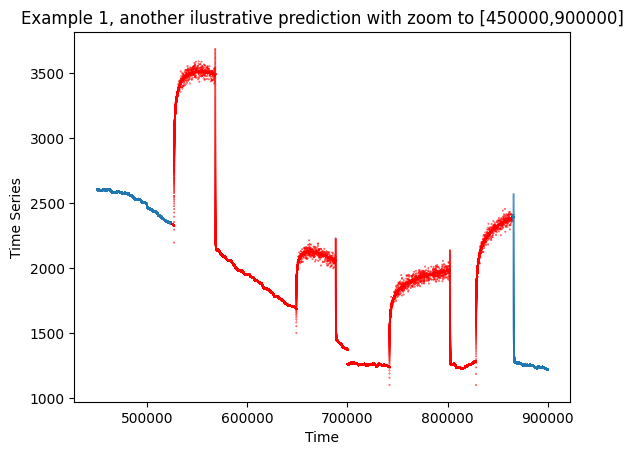

In [30]:
# Visualization of the data and an illustrative prediction: y over time, red color within predicted shut in intervals 
# zoom to [450000,900000] 
plot_well(example1_illustrative_prediction,example1,start=450000,end=900000, title="Example 1, another ilustrative prediction with zoom to [450000,900000]",s=0.1)

### Example 2 

An illustrative prediction

In [31]:
# Reading prediction from baseline intervals
example2_illustrative_prediction1 = pd.read_csv("data/baseline_intervals/example2_prediction2.csv")

In [32]:
# Converting into a list of intervals
example2_illustrative_prediction1 = list(zip(example2_illustrative_prediction1.start,example2_illustrative_prediction1.stop))

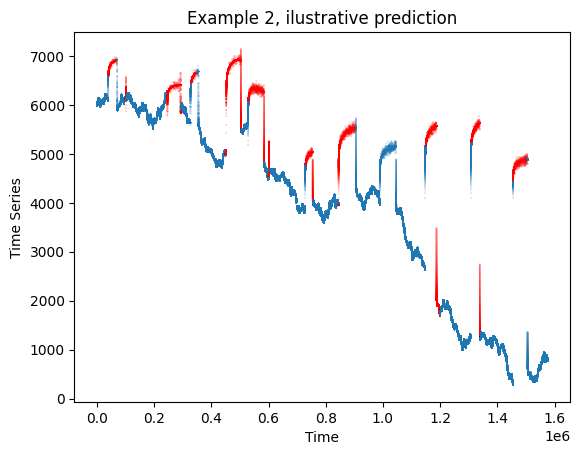

In [33]:
# Visualization of the data and ilustrative prediction: y over time, red color within predicted shut in intervals
plot_well(example2_illustrative_prediction1,example2,title="Example 2, ilustrative prediction",s=0.01)

More intervals seem to be identified

Another illustrative prediction: A list of intervals created directly 

In [34]:
example2_solution_intervals3= [(250000.0, 400000),[450000,550000], [599000,602000],
 (730000.0, 755000),
 (845020.0, 905489),
 (989330.0, 1046260),
 (1147418.0, 1187292),
 (1307376.0, 1338467),
 (1454844.0, 1505710)]

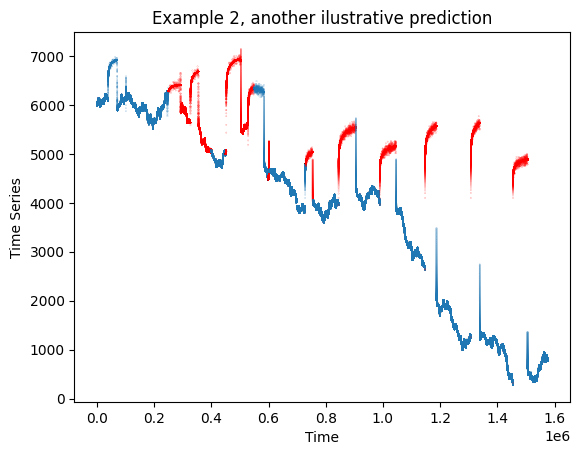

In [35]:
# Visualization of the data and another ilustrative prediction: y over time, red color within predicted shut in intervals
plot_well(example2_solution_intervals3,example2,title="Example 2, another ilustrative prediction",s=0.01)

#  3. Building and using a predictive model

## 3.1. Training 

You can use files in the folder `data/train/` to train and validate a model. 
You have 200 pairs of well time series files and ground truth label files to do so yourself.

As we mentioned before, each `name.csv` time series file matches an unique `name_intervals.csv` label file.

You are free to use all provided data, but for the purpose of this starter notebook we will limit it to only two wells, `example1` and `example2`.

### Preparing training data and ground truth labels

We begin with a list of the respective file names and lists of ground truth labels.

In [36]:
# Time series files:
# list [DataFilename1,DataFilename2,...] 
data_files= ["data/train/example1.csv","data/train/example2.csv"]

In [37]:
# Ground truth label for example 1 and for example 2
ground_truth_labels=[example1_ground_truth_label,example2_ground_truth_label]

We created the class `DataObject` for you to use in this challenge.  
A `DataObject` instance has the following attributes: name (of the well data file), data (well DataFrame), and two optional ones: actual_intervals and predicted_intervals. Learn more about this class in the `utils.py` file.

Thus, given a list of well data filenames a solution is a list of `DataObject` instances, each one with predicted_intervals.

Data and ground truth labels will be stored in instances of the DataObject class you created. It allows you to link well data, predicted intervals and actual intervals in case they are known.

Next, create the list of `DataObject` instances.

Instances in `only_train`: 
1) name='data/train/example1.csv', data=example1, actual_intervals=ground_truth_labels[0]=example1_ground_truth_label
2) name='data/train/example2.csv', data=example2, actual_intervals=ground_truth_labels[1]=example2_ground_truth_label

In [38]:
# Data with labels:
# to apply them predict and evalaute results
only_train=add_intervals(data_files,ground_truth_labels,is_actual=True)

Now explore `only_train`

In [39]:
only_train[0].name

'data/train/example1.csv'

In [40]:
only_train[1].name

'data/train/example2.csv'

In [41]:
only_train[0].data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576800 entries, 0 to 1576799
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   time    1576800 non-null  float64
 1   y       1576703 non-null  float64
dtypes: float64(2)
memory usage: 24.1 MB


In [42]:
only_train[1].data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576800 entries, 0 to 1576799
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   time    1576800 non-null  float64
 1   y       1201702 non-null  float64
dtypes: float64(2)
memory usage: 24.1 MB


In [43]:
only_train[0].actual_intervals

[(55613, 90222),
 (101241, 101544),
 (256613, 296764),
 (347872, 391785),
 (401269, 401475),
 (527030, 568054),
 (649037, 688258),
 (741955, 802294),
 (828360, 865777),
 (992950, 1019856),
 (1135027, 1180801),
 (1250239, 1250499),
 (1460336, 1520206)]

In [44]:
only_train[1].actual_intervals

[(38942, 70899),
 (101261, 101574),
 (246391, 292265),
 (326942, 354777),
 (452226, 503362),
 (528543, 584561),
 (601308, 601638),
 (727945, 754252),
 (845021, 905489),
 (989331, 1046260),
 (1147420, 1187292),
 (1307377, 1338467),
 (1454845, 1505710)]

### Generating a simple model with a particular approach.

This model is based on the [find_peaks function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)

The model is structured as an instance of the class `SimpleModel`, that we created for this example. Learn more about this class in `utils.py`.

You can reuse this class to build and use your model, adapting the arguments for the constructor '__init__', as well as the SimpleModel functions `fit` and `predict`.

You have a big space to use your creativity in solving this challenge. You can completely change the way the model is trained, exploring different learning approaches

#### Initializing the model

In [45]:
model=SimpleModel(0,0)

Model fitting

In [46]:
model.fit(only_train)

Printing our model results: model coefficients

In [47]:
print(model.avg_interval_length, model.avg_time_diff)

33260.5 84265.58333333333


## 3.2. Predicting

Now use the trained model to predict labels; that is to say, the lists of intervals.

Note that `predict` receives a model, a previously trained instance with the available function `model.predict`, and a list of `DataObject` instances and gives the same list as output, but includes the `predicted_intervals` for each instance (check `predict` in `utils.py`). Note it calls `model.predict` at each `DataObject` instance.

First, use the model to predict intervals for the same list of `DataObject` instances that were trained, `only_train`.

Predicting a label, list of intervals, for every instance in `only_train`

In [ ]:
predictionDataObjects=predict(model, only_train)

Let's explore the predictions

In [ ]:
# Predicting a label, list of intervals, for every instance in 'only_train'
predictionDataObjects=predict(model, only_train)

Reviewing prediction for `example1` (first cell of data_files)

In [50]:
predictionDataObjects[0].predicted_intervals

[(87471.0, 101241.0),
 (229799.0, 294765.0),
 (294765.0, 347872.0),
 (347872.0, 419399.0),
 (419399.0, 506399.0),
 (506399.0, 568054.0),
 (568054.0, 623999.0),
 (623999.0, 688258.0),
 (688258.0, 741955.0),
 (741955.0, 865777.0),
 (865777.0, 873599.0),
 (992950.0, 1019856.0),
 (1019856.0, 1117199.0),
 (1117199.0, 1180801.0),
 (1180801.0, 1250239.0),
 (1250239.0, 1355399.0),
 (1355399.0, 1460336.0),
 (1460336.0, 1520206.0),
 (1520206.0, 1520206.0)]

Reviewing prediction for example 2 (second cell of `data_files`)

In [51]:
predictionDataObjects[1].predicted_intervals

[(64190.0, 101261.0),
 (256495.0, 344394.0),
 (344394.0, 374399.0),
 (374399.0, 503362.0),
 (503362.0, 528543.0),
 (528543.0, 620999.0),
 (620999.0, 674999.0),
 (674999.0, 752158.0),
 (752158.0, 793199.0),
 (793199.0, 905489.0),
 (905489.0, 934799.0),
 (934799.0, 1028034.0),
 (1028034.0, 1147419.0),
 (1147419.0, 1174667.0),
 (1174667.0, 1278599.0),
 (1278599.0, 1334848.0),
 (1334848.0, 1454399.0),
 (1454399.0, 1504537.0),
 (1504537.0, 1574999.0),
 (1574999.0, 1574999.0)]

Now, use the model to predict intervals with another list of `DataObject` instances

Files to predict the shut ins

In [52]:
data_files_test=['data/train/test1.csv', 'data/train/test2.csv', 'data/train/test3.csv']

Create a list of `DataObject` instances to call `predict`.

Instances in `only_test`: 
1) name=''data/train/test1.csv'', data=test1, 
2) name=''data/train/test2.csv'', data=test2, 
3) name=''data/train/test3.csv'', data=test3, 

In [53]:
only_test=[]
for i in range(0,len(data_files_test)):
    name=data_files_test[i]
    data=pd.read_csv(name,sep="\t")
    instance_i=DataObject(name,data)
    only_test.append(instance_i)

Predicting lists of intervals for these data wells

In [ ]:
predictionDataObjects_test=predict(model, only_test)

Let's explore predicted intervals

In [55]:
predictionDataObjects_test[0].predicted_intervals

[(47996.0, 92203.0),
 (92203.0, 176766.0),
 (176766.0, 312599.0),
 (312599.0, 389349.0),
 (389349.0, 535199.0),
 (535199.0, 567263.0),
 (567263.0, 657092.0),
 (657092.0, 686999.0),
 (686999.0, 779399.0),
 (779399.0, 818838.0),
 (818838.0, 962336.0),
 (962336.0, 962441.0),
 (962441.0, 1087199.0),
 (1087199.0, 1147307.0),
 (1147307.0, 1208399.0),
 (1208399.0, 1281548.0),
 (1418327.0, 1442999.0),
 (1442999.0, 1552799.0),
 (1552799.0, 1565999.0),
 (1565999.0, 1565999.0)]

In [56]:
predictionDataObjects_test[1].predicted_intervals

[(2399.0, 91955.0),
 (91955.0, 211799.0),
 (211799.0, 285673.0),
 (285673.0, 329999.0),
 (449399.0, 480433.0),
 (598718.0, 636599.0),
 (636599.0, 777853.0),
 (777853.0, 842999.0),
 (842999.0, 974131.0),
 (974131.0, 1028399.0),
 (1028399.0, 1094999.0),
 (1094999.0, 1145999.0),
 (1145999.0, 1265307.0),
 (1265307.0, 1306799.0),
 (1306799.0, 1438562.0),
 (1438562.0, 1449599.0),
 (1449599.0, 1556399.0),
 (1556399.0, 1575599.0),
 (1575599.0, 1575599.0)]

# 4. Generation of a Submission File

To review your results you must submit them in the proper format.
The submission is a json file like this $\{name_1:prediction_1,name_2:predictions_2,\ldots\}$
For this example, consider only two wells, `example1` and `example2` with respective baseline predictions, but for your submission you have to generate it for the 11 test wells we have provided you.  

Starting from a list of `data_files` and another of `predicted_labels`, we build the list of `DataObject` instances including `predicted_intervals` for each instance and, finally, we create the submission in dictionary format and save it into a json file ready for submission

In [57]:
data_files

['data/train/example1.csv', 'data/train/example2.csv']

In [58]:
examples1_2_baseline_predictions= [example1_baseline_prediction,example2_baseline_prediction]

In [59]:
DataObject_list_examples1_2_baseline_predictions=add_intervals(data_files,examples1_2_baseline_predictions)

Let's explore the `DataObject` list, `DataObject_list_examples1_2_baseline_predictions`

In [60]:
DataObject_list_examples1_2_baseline_predictions[0].name

'data/train/example1.csv'

In [61]:
DataObject_list_examples1_2_baseline_predictions[0].predicted_intervals

[(55612, 90222), (101240, 101544), (256612, 296764)]

In [62]:
DataObject_list_examples1_2_baseline_predictions[1].name

'data/train/example2.csv'

In [63]:
DataObject_list_examples1_2_baseline_predictions[1].predicted_intervals

[(601307, 601638),
 (727944, 754252),
 (845020, 905489),
 (989330, 1046260),
 (1147418, 1187292),
 (1307376, 1338467),
 (1454844, 1505710)]

You can also use the `add_intervals` function interactively, to add predictions one by one.
Here, given the list of `DataObject` instances: `[example_solutions1DataObject_list_examples1_2_baseline_predictions[0]]` registers only the data and prediction for example 1, it adds the data and prediction for the example 2

In [64]:
DataObject_list_examples1_2_baseline_predictions_iter=add_intervals([data_files[1]],[examples1_2_baseline_predictions[1]],current_solutions=[DataObject_list_examples1_2_baseline_predictions[0]])

In [65]:
DataObject_list_examples1_2_baseline_predictions_iter[1].name

'data/train/example2.csv'

In [66]:
DataObject_list_examples1_2_baseline_predictions_iter[1].predicted_intervals

[(601307, 601638),
 (727944, 754252),
 (845020, 905489),
 (989330, 1046260),
 (1147418, 1187292),
 (1307376, 1338467),
 (1454844, 1505710)]

### Now we create the submission file

Step by step:

1. Creating the submission dictionary

In [67]:
submission_dict_examples1_2_baseline_predictions=create_submission_dictionary(DataObject_list_examples1_2_baseline_predictions)
submission_dict_examples1_2_baseline_predictions

{'data/train/example1.csv': [(55612, 90222),
  (101240, 101544),
  (256612, 296764)],
 'data/train/example2.csv': [(601307, 601638),
  (727944, 754252),
  (845020, 905489),
  (989330, 1046260),
  (1147418, 1187292),
  (1307376, 1338467),
  (1454844, 1505710)]}

2. Exporting the submission dictionary to a json file

In [68]:
save_submission_to_json(submission_dict_examples1_2_baseline_predictions,"sample_submissions/submission_examples1_2_baseline_predictions.json")

In one command line:

The function `save_submission_to_json` allows you generate the json file directly from the list of DataObject instances

In [69]:
sample_submission_generator(DataObject_list_examples1_2_baseline_predictions,"sample_submissions/submission_examples1_2_baseline_predictions.json")

# 5. Evaluation

Evaluating the performance of your model is key for your success in this challenge

To evaluate your solution's performance, you'll need to submit a JSON file containing the predicted intervals for the test dataset. This submission should be structured as follows `{file_name_1 : [l1, l2, …], file_name_2 : [l1, l2, …]}` in which each `file_name` corresponds to the well name and each predicted_interval li is a tuple in the form `(starti, stopi)`. Evaluation of your submission will use a weighted score:

$$ S=\frac{1\times IoU+2\times Start_{error}+3\times F_{\beta}}{6}$$

where 1, 2, and 3 are the weights for each component, and $\beta=0.5$ to give more importance to Precision than Recall.

IoU: is an averaged [intersection over union](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html) which compares the total intersections of the length of predicted intervals $l_i$ to the length of total unions $L_i$ across all paired intervals $IoU=\sum _il_i/\sum _iL_i$.

$F_{Beta}=((1+\beta ^2)\times Precison \times Recall))/(\beta ^2\times Precison + Recall)$.

Recall is the recall rate, which in this case is the number of predicted shut-ins that match actual shut-ins divided by the number of actual shut-ins. Precision is the precision, which is the number of predicted shut-ins that match actual shut-ins divided by the number of predictions. 

$Start_{error}$: is an exponential decay of the time between the predicted shut-in start and the actual shut-in start $|true_{start}- predicted_{start}|$, where $true_{start}$ is the actual shut-in start time, $predicted_start$ is the predicted shut-in start time, n is the number of shut-ins, and $\tau=5$ if $predicted_{start} > true_{start}$ and $\tau=10$ otherwise.

As shown in previous block, we've included a `sample_submission_generator()` function in the `utils.py` module that generates and saves a sample submission file in JSON format, illustrating the expected format. Additionally, you'll find a sample submission files in the sample_submissions folder. For your submission to be correly analyzed it must adhere to this format. It will be rejected if not.

Here is a guide to evaluate the performance of your model using this scoring metric.

First we evaluate an individual prediction. After that for a list of predictions as an `DataObject` list

## 5.1. Baseline and illustrative predictions

Let's consider `example1`

In [70]:
# Score
get_metrics(example1_ground_truth_label, example1_baseline_prediction, output_option="final_score")

0.7682724785401618

In addition you can explore the components of this score

IoU, $Start_{error}$, Recall, Precision

In [71]:
# Obtaining metrics
# IoU
get_metrics(example1_ground_truth_label, example1_baseline_prediction, output_option="average_iou")

0.9999600351690512

In [72]:
# NegExpDiffStarts
get_metrics(example1_ground_truth_label, example1_baseline_prediction, output_option="NegExpDiffStarts")

0.9048374180359596

In [73]:
# Recall
get_metrics(example1_ground_truth_label, example1_baseline_prediction, output_option="Recall")

0.23076923076923078

In [74]:
# Precision
get_metrics(example1_ground_truth_label, example1_baseline_prediction, output_option="Precision")

1.0

You can obtain the predicted intervals - ground truth intervals matching for each IoU, $|true_{start}- predicted_{start}|$, and $Start_{error}$

In [75]:
# Checking matches
# list with tuples (true_start, true_end, best_predicted_interval, best_iou, |true_{start}- predicted_{start}|, Starts_error)
assign_intervals_and_calculate_iou(example1_ground_truth_label, example1_baseline_prediction, output_option="assigned_pairs")

[(55613, 90222, (55612, 90222), 0.9999711066165848, 1, 0.9048374180359595),
 (101241, 101544, (101240, 101544), 0.9967105263157895, 1, 0.9048374180359595),
 (256613, 296764, (256612, 296764), 0.9999750946403666, 1, 0.9048374180359595)]

You can explore `predicted_intervals` without matches (False positives) or actual intervals without matches (False negatives)

In [76]:
# list of False positives
assign_intervals_and_calculate_iou(example1_ground_truth_label, example1_baseline_prediction, output_option="unassigned_predicted")

[]

In [77]:
# list of False negatives
assign_intervals_and_calculate_iou(example1_ground_truth_label, example1_baseline_prediction, output_option="unassigned_real")

[(347872, 391785),
 (401269, 401475),
 (527030, 568054),
 (649037, 688258),
 (741955, 802294),
 (828360, 865777),
 (992950, 1019856),
 (1135027, 1180801),
 (1250239, 1250499),
 (1460336, 1520206)]

With the illutrative prediction `example1_illustrative_prediction`

In [78]:
# Final score
# IoU+2*NegExpDiffStarts+Recall+0.5*Precision
get_metrics(example1_ground_truth_label, example1_illustrative_prediction, output_option="final_score")

0.460854255886264

## 5.2. List of predictions

First we register the actual_intervals into the solutions annotated in the `DataObject` list `DataObject_list_examples1_2_baseline_predictions`. The resulting list is called `DataObject_list_examples1_2_baseline_predictions_truth`

In [79]:
DataObject_list_examples1_2_baseline_predictions_truth=register_actual_intervals(DataObject_list_examples1_2_baseline_predictions, [example1_ground_truth_label,example2_ground_truth_label])

Let's explore it

In [80]:
DataObject_list_examples1_2_baseline_predictions_truth[0].name

'data/train/example1.csv'

In [81]:
DataObject_list_examples1_2_baseline_predictions_truth[0].predicted_intervals

[(55612, 90222), (101240, 101544), (256612, 296764)]

In [82]:
DataObject_list_examples1_2_baseline_predictions_truth[0].actual_intervals

[(55613, 90222),
 (101241, 101544),
 (256613, 296764),
 (347872, 391785),
 (401269, 401475),
 (527030, 568054),
 (649037, 688258),
 (741955, 802294),
 (828360, 865777),
 (992950, 1019856),
 (1135027, 1180801),
 (1250239, 1250499),
 (1460336, 1520206)]

In [83]:
DataObject_list_examples1_2_baseline_predictions_truth[1].name

'data/train/example2.csv'

In [84]:
DataObject_list_examples1_2_baseline_predictions_truth[1].predicted_intervals

[(601307, 601638),
 (727944, 754252),
 (845020, 905489),
 (989330, 1046260),
 (1147418, 1187292),
 (1307376, 1338467),
 (1454844, 1505710)]

In [85]:
DataObject_list_examples1_2_baseline_predictions_truth[1].actual_intervals

[(38942, 70899),
 (101261, 101574),
 (246391, 292265),
 (326942, 354777),
 (452226, 503362),
 (528543, 584561),
 (601308, 601638),
 (727945, 754252),
 (845021, 905489),
 (989331, 1046260),
 (1147420, 1187292),
 (1307377, 1338467),
 (1454845, 1505710)]

Now we compute the score for this list of predictions.

We compute the score for every instance and average them. Default score `final_score` but can get the different components too

In [86]:
# Score: Average of performance score across all the instances
get_avg_metrics(DataObject_list_examples1_2_baseline_predictions_truth)

0.8296377768990455

In [87]:
# IoU: Average of performance score across all the instances
get_avg_metrics(DataObject_list_examples1_2_baseline_predictions_truth,"average_iou")

0.9999649725811592

In [88]:
# NegExpDiffStarts: Average of performance score across all the instances
get_avg_metrics(DataObject_list_examples1_2_baseline_predictions_truth,"NegExpDiffStarts")

0.8986869419675325

In [89]:
# Recall: Average of performance score across all the instances
get_avg_metrics(DataObject_list_examples1_2_baseline_predictions_truth,"Recall")

0.3846153846153846

In [90]:
# Precision: Average of performance score across all the instances
get_avg_metrics(DataObject_list_examples1_2_baseline_predictions_truth,"Precision")

1.0

#### Now we evaluate predictions with the simple trained model 

First let's consider `predictionDataObjects`, the model predictions for `example1` and `example2` data, same used for training the model

We register the ground truth labels in `actual_intervals`

In [91]:
# Results with trained simple model
# Annotating actual intervals
ModelSimpleDataObjects=register_actual_intervals(predictionDataObjects, [example1_ground_truth_label,example2_ground_truth_label])

Now we compute the score for these predictions

Average results

Score

In [92]:
# Score: Average of performance score across all the instances
get_avg_metrics(ModelSimpleDataObjects)

0.4803826481603831

You can go inside each well

Results for example 1

In [93]:
get_metrics(ModelSimpleDataObjects[0].actual_intervals,ModelSimpleDataObjects[0].predicted_intervals)

0.5341657552381754

In [94]:
print(assign_intervals_and_calculate_iou(ModelSimpleDataObjects[0].actual_intervals, ModelSimpleDataObjects[0].predicted_intervals, output_option="assigned_pairs"))

[(55613, 90222, (87471.0, 101241.0), 0.060291926010344526, 31858.0, 0.0), (256613, 296764, (229799.0, 294765.0), 0.5697304562084671, 26814.0, 0.0), (347872, 391785, (347872.0, 419399.0), 0.6139359961972402, 0.0, 1.0), (527030, 568054, (506399.0, 568054.0), 0.6653799367447896, 20631.0, 0.0), (649037, 688258, (623999.0, 688258.0), 0.6103580821363545, 25038.0, 0.0), (741955, 802294, (741955.0, 865777.0), 0.4873043562533314, 0.0, 1.0), (992950, 1019856, (992950.0, 1019856.0), 1.0, 0.0, 1.0), (1135027, 1180801, (1117199.0, 1180801.0), 0.7196943492343008, 17828.0, 0.0), (1250239, 1250499, (1250239.0, 1355399.0), 0.002472422974515025, 0.0, 1.0), (1460336, 1520206, (1460336.0, 1520206.0), 1.0, 0.0, 1.0)]


Results for example 2

In [95]:
get_metrics(ModelSimpleDataObjects[1].actual_intervals,ModelSimpleDataObjects[1].predicted_intervals)

0.42659954108259074

In [96]:
assign_intervals_and_calculate_iou(ModelSimpleDataObjects[1].actual_intervals, ModelSimpleDataObjects[1].predicted_intervals, output_option="assigned_pairs")

[(38942, 70899, (64190.0, 101261.0), 0.10765577111314366, 25248.0, 0.0),
 (246391, 292265, (256495.0, 344394.0), 0.3649888268726468, 10104.0, 0.0),
 (326942, 354777, (344394.0, 374399.0), 0.21878753397812756, 17452.0, 0.0),
 (452226, 503362, (374399.0, 503362.0), 0.3965168304087219, 77827.0, 0.0),
 (528543, 584561, (528543.0, 620999.0), 0.6058882062819071, 0.0, 1.0),
 (727945, 754252, (674999.0, 752158.0), 0.3055152486341211, 52946.0, 0.0),
 (845021, 905489, (793199.0, 905489.0), 0.5384985305904355, 51822.0, 0.0),
 (989331, 1046260, (934799.0, 1028034.0), 0.3472335615147899, 54532.0, 0.0),
 (1147420,
  1187292,
  (1147419.0, 1174667.0),
  0.6833446191658515,
  1.0,
  0.9048374180359595),
 (1307377, 1338467, (1278599.0, 1334848.0), 0.4588594908799359, 28778.0, 0.0),
 (1454845,
  1505710,
  (1454399.0, 1504537.0),
  0.9684473114926624,
  446.0,
  4.2703759159206115e-20)]

Now we consider `predictionDataObjects_test` with predictions for a list of tests: [test1, test2 and test3]

We register the ground truth labels in `actual_intervals`

In [97]:
submission_dict_tests1_2_3 = create_submission_dictionary(predictionDataObjects_test)
actual_intervals_tests1_2_3=get_actual_list_intervals_files(submission_dict_tests1_2_3)
actual_intervals_list_tests1_2_3=[]
for i in range(0,len(actual_intervals_tests1_2_3)):
    name=actual_intervals_tests1_2_3[i]
    df_intervals_tests1_2_3=pd.read_csv(name)
    intervals_tests1_2_3=list(zip(df_intervals_tests1_2_3.start,df_intervals_tests1_2_3.stop))
    actual_intervals_list_tests1_2_3.append(intervals_tests1_2_3)
ModelSimpleDataObjects_test=register_actual_intervals(predictionDataObjects_test,actual_intervals_list_tests1_2_3)

Now we compute the score for this list of tests

Average results

Score

In [98]:
# Score: Average of performance score across all the instances
get_avg_metrics(ModelSimpleDataObjects_test)

0.4291328029102746

# 6. Submissions evaluation examples

First is a function to process submission files

In [99]:
def dict2DataObjectList(submission_dict: dict[str, List[tuple]]) -> List[DataObject]:
    """
    Converts a dictionary of name-predicted_intervals pairs to a list of DataObject instances.

    Args:
        submission_dict: A dictionary with names as keys and predicted intervals as values.

    Returns:
        A list of DataObject objects with corresponding names and predicted intervals.
    """

    data_object_list = []
    for name, predicted_intervals in submission_dict.items():
        data_object = DataObject(name, None)  # Assuming you don't have actual data in the dictionary
        data_object.assign_intervals(predicted_intervals, is_actual=False)
        data_object_list.append(data_object)

    return data_object_list

In [100]:
def register_actual_intervals_brackets(solutions: List[DataObject], actual_intervals: List[List[tuple]]) -> List[DataObject]:
    """
    Adds actual intervals to each DataObject in the solutions list.

    Args:
        solutions: A list of DataObject instances.
        actual_intervals: A list of lists of actual intervals (start, stop) corresponding to each DataObject.

    Returns:
        A list of DataObject instances with updated actual_intervals attributes.
    """

    if len(solutions) != len(actual_intervals):
        raise ValueError("Number of solutions and actual intervals must be equal.")

    for solution, intervals in zip(solutions, actual_intervals):
        solution.actual_intervals = intervals
    
    def brackets2parentheses(list_intervals):
        list_intervals_paretheses=[]
        for interval in list_intervals:
            list_intervals_paretheses.append(tuple(interval))
        return list_intervals_paretheses
    
    def brackets2parenthesesPredictions(solutions: List[DataObject]):
        results = solutions.copy()
        for i in range(0,len(solutions)):
            results[i].predicted_intervals=brackets2parentheses(solutions[i].predicted_intervals)
        return results

    results=brackets2parenthesesPredictions(solutions)
    
    return results

In [101]:
def get_score_from_submission_file(submission_file="/sample_submissions/submission_test.json",metric_option="final_score"):
    """
    Read a submitted solution and return the average score contrasting with actual solutions on the associated filenames
    
    Args:
        submission_file: A submitted solution in json format
        metric_option: String specifying the desired metric to compute, valid options are:
                       final_score, average_iou, NegExpDiffStarts, Recall, or Precision.
                       
    Returns:
        The average of the specified metric across all predicted intervals in the submitted solution.
    """
    f = open(submission_file)
    submitted_dict = json.load(f)
    actual_intervals=get_actual_list_intervals_files(submitted_dict)
    solutions=dict2DataObjectList(submitted_dict)
    actual_intervals_list=[]
    for i in range(0,len(actual_intervals)):
        name=actual_intervals[i]
        df_intervals=pd.read_csv(name)
        intervals=list(zip(df_intervals.start,df_intervals.stop))
        actual_intervals_list.append(intervals)
    results=register_actual_intervals_brackets(solutions,actual_intervals_list)
    return get_avg_metrics(results, metric_option)

Now generate a submission file. In this case predictions for the well data files test1, test2, test3

List of well data filenames for which we predicted intervals: `data_files_test`

In [102]:
data_files_test

['data/train/test1.csv', 'data/train/test2.csv', 'data/train/test3.csv']

Predictions for these data wells in `predictionDataObjects_test`

Generating and saving the submission file

In [103]:
sample_submission_generator(predictionDataObjects_test,"sample_submissions/submission_tests1_2_3.json")

Now compute the average score for predictions across the analyzed well data files 

In [104]:
get_score_from_submission_file("sample_submissions/submission_tests1_2_3.json")

0.4291328029102746

Calculate the score for other submissions in `sample_submissions` 

Baseline solutions for `example1` and `example2`

In [105]:
get_score_from_submission_file("sample_submissions/submission_examples1_2_baseline_predictions.json")

0.8296377768990455

Visual guessing for `example1` and for `example2`

In [106]:
get_score_from_submission_file("sample_submissions/submission_test2.json")

0.5374023784999048

Visual guessing for `example1` and improved visual guessing for `example2`

In [107]:
get_score_from_submission_file("sample_submissions/submission_test3.json")

0.5991335251767365

Baseline solution for `example1` and visual guessing for `example2`

In [108]:
get_score_from_submission_file("sample_submissions/submission_test1-2.json")

0.6911114898268538

Visual guessing for `example1` and baseline solution for `example2`

In [109]:
get_score_from_submission_file("sample_submissions/submission_test2-1.json")

0.6759286655720966

### A perfect match

In [110]:
data_files

['data/train/example1.csv', 'data/train/example2.csv']

In [111]:
ground_truth_labels

[[(55613, 90222),
  (101241, 101544),
  (256613, 296764),
  (347872, 391785),
  (401269, 401475),
  (527030, 568054),
  (649037, 688258),
  (741955, 802294),
  (828360, 865777),
  (992950, 1019856),
  (1135027, 1180801),
  (1250239, 1250499),
  (1460336, 1520206)],
 [(38942, 70899),
  (101261, 101574),
  (246391, 292265),
  (326942, 354777),
  (452226, 503362),
  (528543, 584561),
  (601308, 601638),
  (727945, 754252),
  (845021, 905489),
  (989331, 1046260),
  (1147420, 1187292),
  (1307377, 1338467),
  (1454845, 1505710)]]

In [112]:
perfect_intervals_examples1_2=add_intervals(data_files,ground_truth_labels,is_actual=False)

Generating and saving the submission file

In [113]:
sample_submission_generator(perfect_intervals_examples1_2,"sample_submissions/submission_perfect_examples1_2.json")

Reading the submission and computing the score

In [114]:
get_score_from_submission_file("sample_submissions/submission_perfect_examples1_2.json")

1.0

### Wrong predictions: (0,len(data)) interval

In [115]:
wrong_0_len_interval_examples1_2=add_intervals(data_files,[[(0,len(example1))],[(0,len(example2))]],is_actual=False)

Generating and saving the submission file

In [116]:
sample_submission_generator(wrong_0_len_interval_examples1_2,"sample_submissions/submission_wrong_0_len_interval_examples1_2.json")

In [117]:
get_score_from_submission_file("sample_submissions/submission_wrong_0_len_interval_examples1_2.json")

0.1505768135513972

### Wrong predictions: no intersecting interval

In [118]:
wrong_no_intersecting_interval_examples1_2=add_intervals(data_files,[[(580000,630000)],[(650000,700000)]],is_actual=False)

Generating and saving the submission file

In [119]:
sample_submission_generator(wrong_no_intersecting_interval_examples1_2,"sample_submissions/submission_wrong_no_intersecting_interval_examples1_2.json")

In [120]:
get_score_from_submission_file("sample_submissions/submission_wrong_no_intersecting_interval_examples1_2.json")

0.0